In [120]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt

from qclassifier.models import ClassifierSingleQubitChunked, ClassifierSingleQubit, ClassifierMultiQubit
from qclassifier.datasets import get_sample_data
from qclassifier.visualization import plot_problem, plot_prediction, plot_on_bloch_sphere
from qclassifier.training_tools import best_initial_conditions, train, test, classify

Data has dimension 2
There are 4 classes


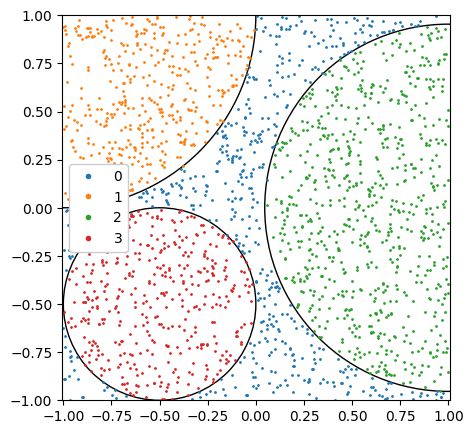

In [104]:
# Load the 3 circles dataset and visualize it
dataset_name = '3 circles'

data_train, data_test = get_sample_data(dataset_name, N_train = 1000, N_test = 2000)
D = data_train[0].shape[1]
C = len(torch.unique(data_train[1]))

print(f'Data has dimension {D}')
print(f'There are {C} classes')

plot_problem(data_test[0],data_test[1],dataset_name)


In [122]:
# Initialize a simple model containing 1 layer, based on the paper "Data
# re-uploading for a universal quantum classifier".
L = 1
model = ClassifierSingleQubitChunked(D = D, L = L, C = C)  


In [123]:
# Find the best initial conditions    
model = best_initial_conditions(model, data_train, samples=20, batch_size = 200, epochs = 5)

# Fit the model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
stats = train(model, optimizer, data_train, data_test, epochs = 500, batch_size = 200, patience = 25)

# Evaluate the final test accuracy and predictions
accuracy = test(model, data_test, batch_size = 200)
Y_pred = classify(model, data_test[0], batch_size = 200)


 21%|██        | 103/500 [00:11<00:44,  8.98it/s, Train loss=0.18, Train accuracy=0.771, Test loss=0.183, Test accuracy=0.786]


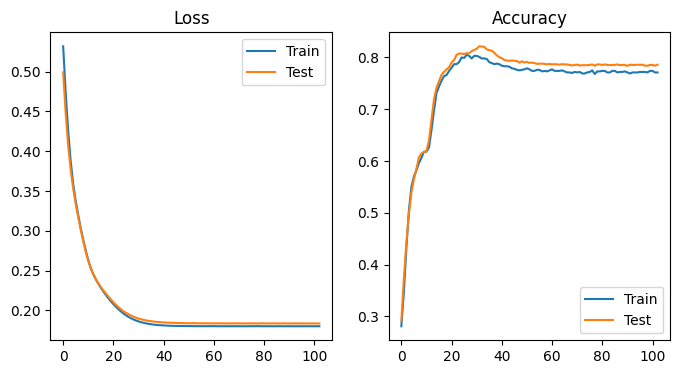

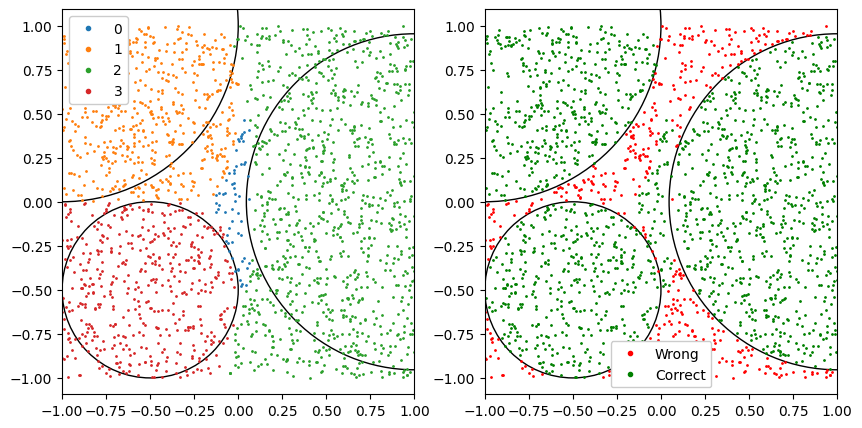

In [124]:
# Visualize the training result
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
plt.plot(stats['Train loss'])
plt.plot(stats['Test loss'])
plt.title('Loss')
plt.legend(['Train','Test'])

plt.subplot(1,2,2)
plt.plot(stats['Train accuracy'])
plt.plot(stats['Test accuracy'])
plt.title('Accuracy')
plt.legend(['Train','Test'])
plt.show()

# Visualize the predictions
plot_prediction(data_test[0], data_test[1], Y_pred, dataset_name)

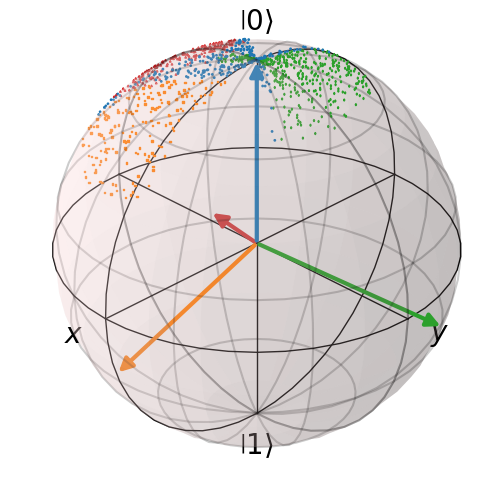

In [129]:
# Show the predictions/encodings on the Bloch sphere
%matplotlib widget

rho = torch.squeeze(model(data_train[0]))
plot_on_bloch_sphere(rho, data_train[1], model.psi_c, view = [-45,30])


100%|██████████| 500/500 [04:15<00:00,  1.95it/s, Train loss=0.0949, Train accuracy=0.951, Test loss=0.1, Test accuracy=0.939]  


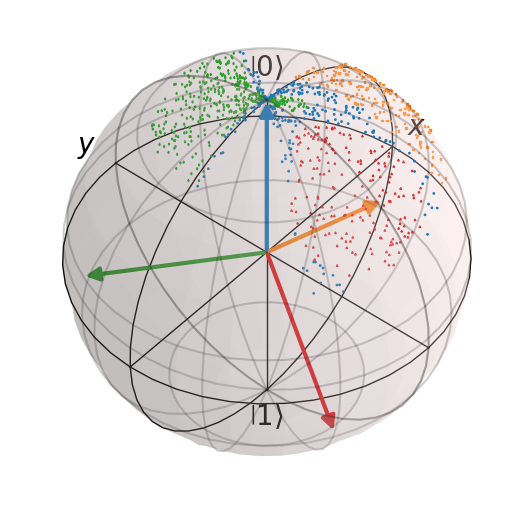

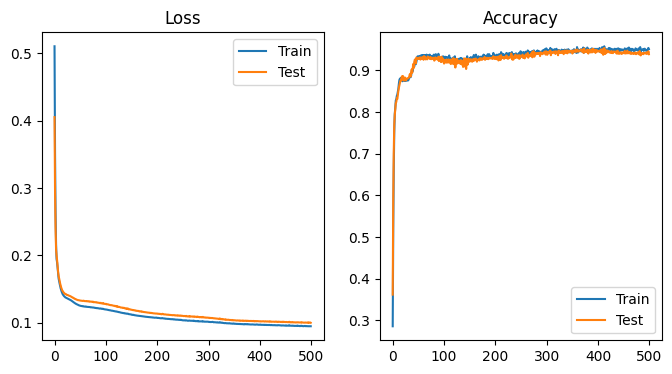

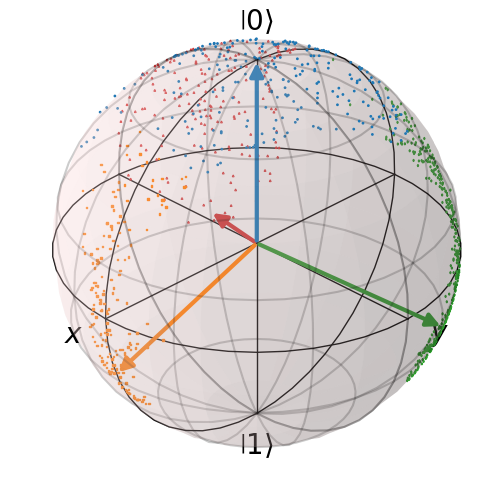

In [130]:
# Repeat for a bigger model
L = 8
model = ClassifierSingleQubitChunked(D = D, L = L, C = C)  

model = best_initial_conditions(model, data_train, samples=20, batch_size = 200, epochs = 5)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
stats = train(model, optimizer, data_train, data_test, epochs = 500, batch_size = 200, patience = 25)

accuracy = test(model, data_test, batch_size = 200)
Y_pred = classify(model, data_test[0], batch_size = 200)


%matplotlib inline

plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
plt.plot(stats['Train loss'])
plt.plot(stats['Test loss'])
plt.title('Loss')
plt.legend(['Train','Test'])

plt.subplot(1,2,2)
plt.plot(stats['Train accuracy'])
plt.plot(stats['Test accuracy'])
plt.title('Accuracy')
plt.legend(['Train','Test'])
plt.show()

plot_prediction(data_test[0], data_test[1], Y_pred, dataset_name)

%matplotlib widget

rho = torch.squeeze(model(data_train[0]))
plot_on_bloch_sphere(rho, data_train[1], model.psi_c, view = [-45,30])



In [ ]:
# Repeat for various depths L and different model architectures. Save the final
# test accuracy for each run in order to compare them later
L_values = [i + 1 for i in range(8)]

accuracy_test = np.zeros((len(L_values),3))

for n,L in enumerate(L_values):

    for i in range(3):

        if i == 0:
            model = ClassifierSingleQubitChunked(D = D, L = L, C = C)  
        if i == 1:
            model = ClassifierSingleQubit(D = D, L = L, C = C)  
        if i == 2:
            model = ClassifierMultiQubit(D = D, L = L, C = C)  
  
        model = best_initial_conditions(model, data_train, samples=20, batch_size = 200, epochs = 5)
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
        stats = train(model, optimizer, data_train, data_test, epochs = 500, batch_size = 200, patience = 25)
        accuracy_test[n,i] = test(model, data_test, batch_size = 200)


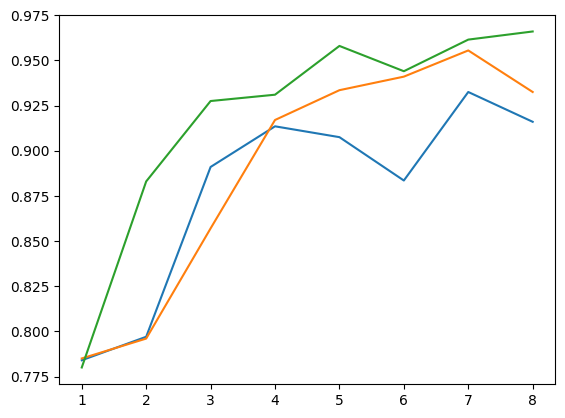

In [118]:
# Compare the accuracy of the models
plt.figure()
plt.plot(L_values,accuracy_test)
plt.show()